In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def read_movie_titles():
    with open('Project2-data/movie_titles.txt', 'r', encoding = "ISO-8859-1") as fp:
        movie_titles = fp.read().splitlines()

    rule = "(\d+),(.*),(.*)"
    l = []
    for title in movie_titles:
        hit = re.match(rule, title)
        l.append([hit[1], hit[2], hit[3]])
    return pd.DataFrame(l, columns=['id', 'mid', 'title'])

def predict(ratings, similarity,):
    # 注意分母，只有看过该电影的人，才能将其打分加入做CF
    return similarity.dot(ratings) / similarity.dot((ratings>0) +  np.finfo(float).eps)

def rmse(mat_pred, mat_test):
    y_pred = mat_pred[mat_test.nonzero()].flatten()
    y_test = mat_test[mat_test.nonzero()].flatten()
    return np.sqrt(mean_squared_error(y_pred, y_test))

## Data Preprocessing

In [2]:
df_title = read_movie_titles()
df_user = pd.read_csv('Project2-data/users.txt', sep=' ', header=None, names=['uid'])
df_train = pd.read_csv('Project2-data/netflix_train.txt', sep=' ', header=None, names=['uid', 'mid', 'rating', 'time'])
df_test = pd.read_csv('Project2-data/netflix_test.txt', sep=' ', header=None, names=['uid', 'mid', 'rating', 'time'])


fake_id = 0
impute = [{'uid': fake_id, 'mid': i, 'rating': 0, 'time': None} for i in range(1, 10000)]
df_test = df_test.append(impute)

rating_train = df_train.pivot(index = 'uid', columns ='mid', values = 'rating').fillna(0)
rating_test = df_test.pivot(index = 'uid', columns ='mid', values = 'rating').fillna(0)
rating_test = rating_test.drop(fake_id)

print("Train shape:", rating_train.shape, "Test shape:", rating_test.shape)

Train shape: (10000, 10000) Test shape: (10000, 10000)


## User-based Collaborative Filtering

In [3]:
start_time = time.time()
print("Calculating cosine similarity")
mat_train = np.array(rating_train)
mat_test = np.array(rating_test)
mat_sim = cosine_similarity(mat_train, dense_output=False)
print("--- %s seconds ---" % (round(time.time() - start_time, 2)))

print("User-based CF: Preditioning...")
mat_pred = predict(mat_train, mat_sim)

print('User-based CF: RMSE: ' + str(rmse(mat_pred, mat_test)))
print("--- %s seconds ---" % (round(time.time() - start_time, 2)))

## See what's really happening
# prediction = mat_pred[mat_test.nonzero()].flatten()
# ground_truth = mat_test[mat_test.nonzero()].flatten()

Calculating cosine similarity
--- 8.24 seconds ---
User-based CF: Preditioning...
User-based CF: RMSE: 1.0183690394072502
--- 39.23 seconds ---


## Matrix Factorization (gradient descent)

In [44]:
import numpy as np
import time
from numpy import linalg as LA


class MF():
    def __init__(self, X, k, lamb, alpha, iterations):
        """
        Perform matrix factorization to predict empty entries in a matrix.
        
        Arguments
        - X (ndarray)   : user-item rating matrix
        - k (int)       : number of latent dimensions
        - lamb (float)  : regularization parameter
        - alpha (float) : learning rate
        """
        self.X = X
        self.A = (X>0)*1
        self.n_users, self.n_items = X.shape
        self.k = k
        self.alpha = alpha
        self.lamb = lamb
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.U = np.random.normal(scale=1./self.k, size=(self.n_users, self.k)) # 10000, k
        self.V = np.random.normal(scale=1./self.k, size=(self.n_items, self.k)) # 10000, k
        
        RMSEs = []
        for i in range(self.iterations):
            start_time = time.time()
            self.gradient_descent()
            RMSE = self.rmse()
            RMSEs.append((i, RMSE))

            if i%10==0:
                J = self.J()
                elasping = time.time() - start_time
                print("Iteration: %d; J=%.3f; RMSE = %.4f; %.2f seconds" % (i+1, J, RMSE, elasping))

        return RMSEs
    
    def J(self):
        loss = self.predict() - self.X
        J = 0.5 * LA.norm(np.multiply(self.A, loss)) + self.lamb * LA.norm(self.U) + self.lamb * LA.norm(self.V)
        return J
    
    def rmse(self):
        """
        A function to compute the total root mean square error
        """
        mat_pred = self.predict()
        y_pred = mat_pred[R.nonzero()].flatten()
        y_test = R[R.nonzero()].flatten()
        return np.sqrt(mean_squared_error(y_pred, y_test))

    def gradient_descent(self):
        """
        Perform graident descent
        """
        loss = self.predict() - self.X
        dU = np.dot(np.multiply(self.A, loss), self.V) + 2 * self.lamb * self.U
        dV = np.dot(np.multiply(self.A, loss).T, self.U) + 2 * self.lamb * self.V
        
        self.U -= self.alpha * dU
        self.V -= self.alpha * dV

    def predict(self):
        return self.U.dot(self.V.T)


R = mat_train
k = 20
lamb = 0.1
mf = MF(R, k=k, lamb=lamb, alpha=0.0001, iterations=150)
rmses = mf.train()

mat_pred = mf.predict()
print('User-based CF: RMSE: ' + str(rmse(mat_pred, mat_test)))

Iteration: 1; rmse = 3.5619; 6.54 seconds
Iteration: 2; rmse = 3.5619; 7.03 seconds
Iteration: 3; rmse = 3.5619; 6.18 seconds
Iteration: 4; rmse = 3.5618; 6.50 seconds
Iteration: 5; rmse = 3.5617; 6.13 seconds
Iteration: 6; rmse = 3.5615; 5.31 seconds
Iteration: 7; rmse = 3.5611; 4.79 seconds
Iteration: 8; rmse = 3.5602; 4.76 seconds
Iteration: 9; rmse = 3.5579; 4.76 seconds
Iteration: 10; rmse = 3.5526; 5.25 seconds
Iteration: 11; rmse = 3.5403; 4.99 seconds
Iteration: 12; rmse = 3.5118; 6.91 seconds
Iteration: 13; rmse = 3.4470; 6.32 seconds
Iteration: 14; rmse = 3.3050; 6.92 seconds
Iteration: 15; rmse = 3.0220; 7.17 seconds
Iteration: 16; rmse = 2.5684; 7.66 seconds
Iteration: 17; rmse = 2.1082; 6.05 seconds
Iteration: 18; rmse = 1.8359; 7.22 seconds
Iteration: 19; rmse = 1.6632; 7.53 seconds
Iteration: 20; rmse = 1.5391; 6.92 seconds
Iteration: 21; rmse = 1.4468; 6.60 seconds
Iteration: 22; rmse = 1.3761; 6.46 seconds
Iteration: 23; rmse = 1.3205; 6.15 seconds
Iteration: 24; rmse 

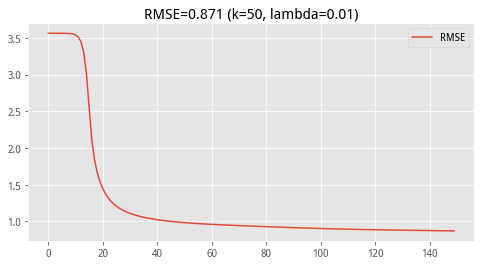

In [47]:
%matplotlib inline
df = pd.DataFrame(rmses, columns=['index', 'RMSE'])['RMSE']
RMSE = rmses[-1][1]
df.plot(figsize=(8,4), legend=True, title=("RMSE=%.3f (k=%d, lambda=%.2f)" % (RMSE, k, lamb)))

## Bouns - extra imformation (time & title)

In [79]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def read_movie_titles():
    with open('Project2-data/movie_titles.txt', 'r', encoding = "ISO-8859-1") as fp:
        movie_titles = fp.read().splitlines()

    rule = "(\d+),(.*),(.*)"
    l = []
    for title in movie_titles:
        hit = re.match(rule, title)
        l.append([hit[1], hit[2], hit[3]])
    return pd.DataFrame(l, columns=['id', 'mid', 'title'])

def predict(ratings, similarity,):
    # 注意分母，只有看过该电影的人，才能将其打分加入做CF
    return similarity.dot(ratings) / similarity.dot((ratings>0) +  np.finfo(float).eps)

def rmse(mat_pred, mat_test):
    y_pred = mat_pred[mat_test.nonzero()].flatten()
    y_test = mat_test[mat_test.nonzero()].flatten()
    return np.sqrt(mean_squared_error(y_pred, y_test))

def preprocess(df):
    df['time'] = pd.to_datetime(df['time'])
    df['year'] = df.time.dt.year
    df['month'] = df.time.dt.month
    df['day'] = df.time.dt.day
    df['dayofweek'] = df.time.dt.dayofweek
    df['dayofyear'] = df.time.dt.dayofyear
    df['weekofyear'] = df.time.dt.weekofyear
    return df.drop(['rating', 'time', 'mid'], axis=1)


df_title = read_movie_titles()
df_user = pd.read_csv('Project2-data/users.txt', sep=' ', header=None, names=['uid'])
df_train = pd.read_csv('Project2-data/netflix_train.txt', sep=' ', header=None, names=['uid', 'mid', 'rating', 'time'])
df_test = pd.read_csv('Project2-data/netflix_test.txt', sep=' ', header=None, names=['uid', 'mid', 'rating', 'time'])

fake_id = 0
impute = [{'uid': fake_id, 'mid': i, 'rating': 0, 'time': None} for i in range(1, 10000)]
df_test = df_test.append(impute)

rating_train = df_train.pivot(index = 'uid', columns ='mid', values = 'rating').fillna(0)
rating_test = df_test.pivot(index = 'uid', columns ='mid', values = 'rating').fillna(0)
rating_test = rating_test.drop(fake_id)
print("Train shape:", rating_train.shape, "Test shape:", rating_test.shape)

# Building date statistic feature for user-similairy matrix
df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all = df_all.dropna()
df_all = preprocess(df_all)
df_onehot = pd.get_dummies(df_all, columns=['year', 'month', 'dayofweek', 'dayofyear', 'weekofyear'])
df_stats = df_onehot.groupby('uid').mean()

print("Calculating cosine similarity")
start_time = time.time()
mat_train = np.array(rating_train.join(df_stats))
mat_test = np.array(rating_test.join(df_stats))
mat_sim = cosine_similarity(mat_train, dense_output=False)
print("--- %s seconds ---" % (round(time.time() - start_time, 2)))

print("User-based CF: Preditioning...")
mat_pred = predict(mat_train, mat_sim)

print('User-based CF: RMSE: ' + str(rmse(mat_pred, mat_test)))
print("--- %s seconds ---" % (round(time.time() - start_time, 2)))

## See what's really happening
# prediction = mat_pred[mat_test.nonzero()].flatten()
# ground_truth = mat_test[mat_test.nonzero()].flatten()

Train shape: (10000, 10000) Test shape: (10000, 10000)
Calculating cosine similarity
--- 8.1 seconds ---
User-based CF: Preditioning...
User-based CF: RMSE: 0.7374302105969455
--- 38.89 seconds ---
